Create Synthetic Data-Set for ML Model

Motiavtion:
  1- To check the behavior of Algorithm,
  2- To understand and visulize how diffrent data distributions look,
  3- What are the optimal strategy for various data distributions.


1. Create Dataset with perfectly known performance of the ml models:

   Binary-Classification, classes are 50:50: 
   Features: Gaussian distribution, classes: 50%-0; 50%-1
   Every model has a true predicting power of 50% accuracy
   Model score = True predicting power?


In [2]:
import numpy as np 
from matplotlib import pyplot as plt 
import random
import seaborn as sns
import pandas as pd
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
#Generates Gaussian distribution data
from sklearn.datasets import make_gaussian_quantiles

In [5]:
#Create Helper function for visulization in 2D
def visualize_2d(X,y,title="2D Data ",figsize=(8,8)):
    #import umap
    #reducer = umap.UMAP()
    if X.shape[1]>2:
        X = reducer.fit_transform(X)
    else:
        if type(X)==pd.DataFrame:
        	X=X.values
    f, (ax1) = plt.subplots(nrows=1, ncols=1,figsize=figsize)
    sns.scatterplot(X[:,0],X[:,1],hue=y,ax=ax1);
    ax1.set_title(title);
    plt.show();

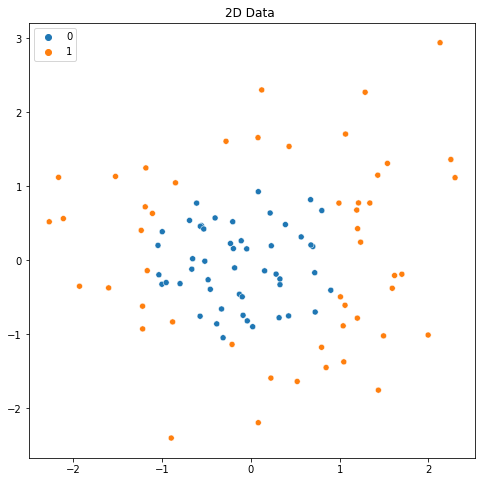

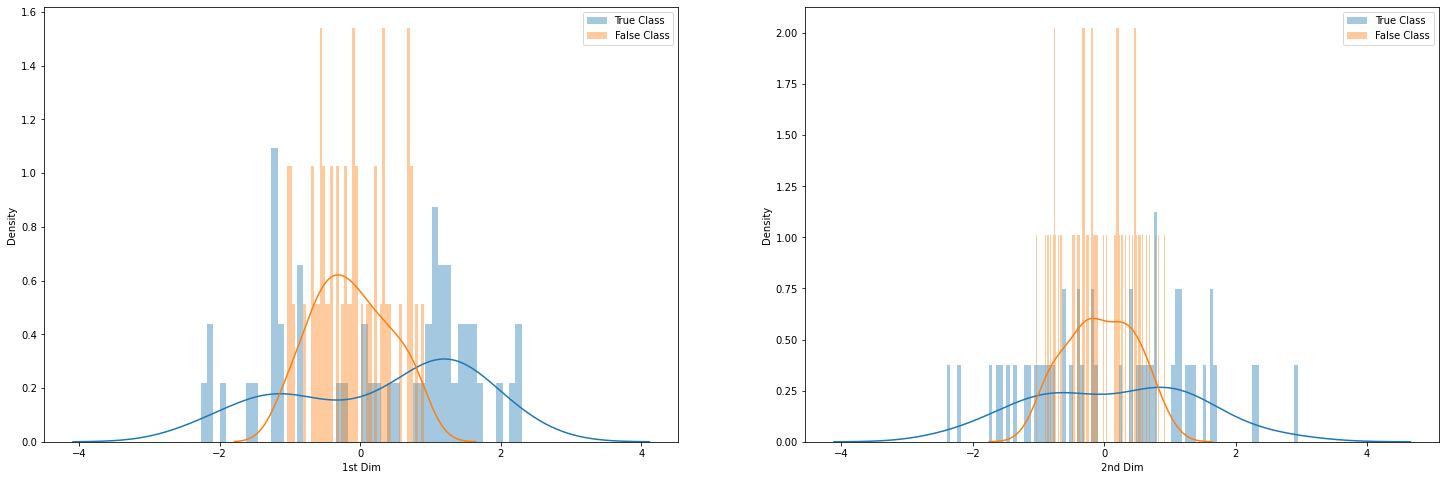

In [6]:
# Construct dataset
X_1, y_1 = make_gaussian_quantiles(n_samples= 100,
                                 n_features=2,
                                 n_classes=2,
                                 )

# transform the dataset
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=1)
X1, y1 = ros.fit_resample(X_1, y_1)



X1 = pd.DataFrame(X1,columns=['x','y'])
y1 = pd.Series(y1)
visualize_2d(X1,y1)


fig, (ax1,ax2) = plt.subplots(1,2,figsize=(25,8))
sns.distplot(X1[y1==1]['x'],bins=50,label="True Class",ax=ax1)
sns.distplot(X1[y1==0]['x'],bins=50,label="False Class",ax=ax1)
ax1.set_xlabel("1st Dim")
ax1.legend()

sns.distplot(X1[y1==1]['y'],bins=100,label="True Class",ax=ax2)
sns.distplot(X1[y1==0]['y'],bins=100,label="False Class",ax=ax2)
ax2.set_xlabel("2nd Dim")
ax2.legend()
plt.show()

  



In [7]:
print(X1.shape, y1.shape)

(100, 2) (100,)


2. Investigate different methods of evaluating the model score

   Cross-Validation,
   Nested-Cross-validation,
   Hold-out,
   Further methods,


Logistic regression is a commonly used technique for solving binary classification problems.
 
In a logistic regression model:

    1-we take linear combination (or weighted sum of the input features)
    2-we apply the sigmoid function to the result to obtain a number between 0 and 1
    3-this number represents the probability of the input being classified as "Yes"
    4-instead of RMSE, the cross entropy loss function is used to evaluate the results

In [8]:
from numpy import mean, std
from sklearn.model_selection import KFold, cross_val_score,GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [9]:
X_train,X_test,y_train,y_test=train_test_split(X1,y1,test_size=0.25,random_state=0)

### Logistic regression

In [10]:
# Create Logistic Model
model1 = LogisticRegression(random_state=42)
model1.fit(X_train, y_train)
model1.score(X_test, y_test)

0.56

In [11]:
y_pred = model1.predict(X_test)

In [12]:
#Model Evaluating using Confusion Matrix
from sklearn import metrics
confusion_Matrix = metrics.confusion_matrix(y_test, y_pred)
print(confusion_Matrix)

[[8 2]
 [9 6]]


Text(0.5, 257.44, 'Predicted label')

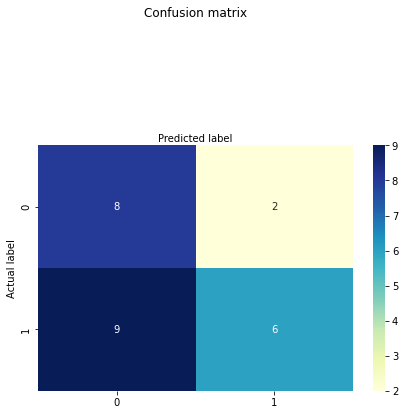

In [13]:
#create Visulization Matrix using Heatmap

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(confusion_Matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.5)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [14]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.56
Precision: 0.75
Recall: 0.4


well I have got a classification rate of 56%, not good accuracy.

Receiver Operating Characteristic(ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity.

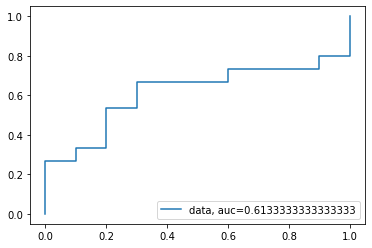

In [15]:
y_pred_proba = model1.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data, auc="+str(auc))
plt.legend(loc=4)
plt.show()

AUC score for the case is 0.65. AUC score 1 represents perfect classifier, and 0.5 represents a worthless classifier.

### Logistic regression model performance using cross_val_score

In [16]:
# To perform cross validation
cv_outer = KFold(n_splits=10, shuffle= True, random_state=1)

# Evaluate model
scores1 = cross_val_score(model1, X1, y1,scoring= 'accuracy', cv=cv_outer, n_jobs=1)
print('Accuracy: %.3f (%.3f)' % (mean(scores1), std(scores1)))

Accuracy: 0.550 (0.102)


### Logistic regression model performance using Nested and Non-Nested CV with GridSearchCV

In [17]:
num_of_rand_trials = 20
X1_data = X1
y1_target = y1

In [18]:
opti_grid_para1 = {"C": [0.01, 0.1, 1, 10, 100],
                  "random_state": [1]}

In [19]:
nested_scores_1  = np.zeros(num_of_rand_trials)
non_nested_scores_1 = np.zeros(num_of_rand_trials)


In [20]:
for i in range(num_of_rand_trials):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits=2, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=model1, param_grid=opti_grid_para1, cv=outer_cv)
    clf.fit(X1_data, y1_target)
    non_nested_scores_1[i] = clf.best_score_

    # Nested CV with parameter optimization
    clf = GridSearchCV(estimator=model1, param_grid=opti_grid_para1, cv=inner_cv)
    nested_score_1 = cross_val_score(clf, X=X1_data, y=y1_target, cv=outer_cv)
    nested_scores_1[i] = nested_score_1.mean()

In [21]:
print(non_nested_scores_1, nested_scores_1)

[0.6  0.58 0.55 0.61 0.6  0.56 0.61 0.59 0.57 0.58 0.61 0.6  0.65 0.6
 0.66 0.6  0.58 0.56 0.49 0.54] [0.6  0.52 0.52 0.59 0.59 0.54 0.6  0.55 0.57 0.55 0.61 0.59 0.59 0.59
 0.66 0.55 0.55 0.53 0.45 0.47]


In [22]:
difference_of_Score = non_nested_scores_1 - nested_scores_1

print(
    "Average difference of {:3f} with std. dev. of {:3f}.".format(
        difference_of_Score.mean(), difference_of_Score.std()
    )
)

Average difference of 0.026000 with std. dev. of 0.021307.


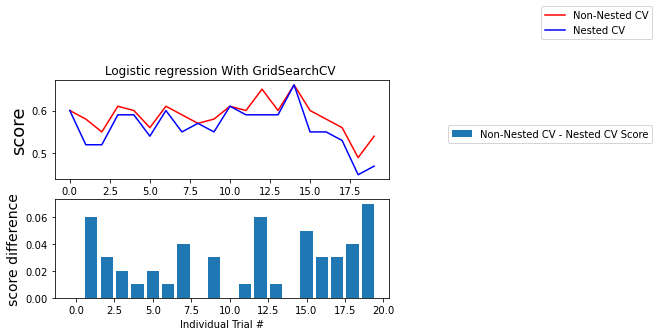

In [23]:
plt.figure()
plt.subplot(211)
plt.title('Logistic regression With GridSearchCV ')
(non_nested_scores_line,) = plt.plot(non_nested_scores_1, color="r")
(nested_line,) = plt.plot(nested_scores_1, color="b")
plt.ylabel("score", fontsize="18")
plt.legend(
    [non_nested_scores_line, nested_line],
    ["Non-Nested CV", "Nested CV"],
    bbox_to_anchor=(0, 1.8, 1.8, 0),
)
plt.subplot(212)
difference_plot = plt.bar(range(num_of_rand_trials), difference_of_Score)
plt.xlabel("Individual Trial #")
plt.legend(
    [difference_plot],
    ["Non-Nested CV - Nested CV Score"],
    bbox_to_anchor=(0, 1.8, 1.8, 0),
)
plt.ylabel("score difference", fontsize="14")

plt.show()

Logistic regression model performance using Nested and Non-Nested CV with RandomSearchCV

In [24]:
for i in range(num_of_rand_trials):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits=2, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=i)

    
    # Non_nested parameter search and scoring
    clf = RandomizedSearchCV(estimator=model1, param_distributions=opti_grid_para1, cv=outer_cv)
    clf.fit(X1_data, y1_target)
    non_nested_scores_1[i] = clf.best_score_

    # Nested CV with parameter optimization
    clf = RandomizedSearchCV(estimator=model1, param_distributions=opti_grid_para1, cv=inner_cv)
    nested_score_1 = cross_val_score(clf, X=X1_data, y=y1_target, cv=outer_cv)
    nested_scores_1[i] = nested_score_1.mean()

In [25]:
print(non_nested_scores_1, nested_scores_1)

[0.6  0.58 0.55 0.61 0.6  0.56 0.61 0.59 0.57 0.58 0.61 0.6  0.65 0.6
 0.66 0.6  0.58 0.56 0.49 0.54] [0.6  0.52 0.52 0.59 0.59 0.54 0.6  0.55 0.57 0.55 0.61 0.59 0.59 0.59
 0.66 0.55 0.55 0.53 0.45 0.47]


In [26]:
difference_of_Score = non_nested_scores_1 - nested_scores_1

print(
    "Average difference of {:3f} with std. dev. of {:3f}.".format(
        difference_of_Score.mean(), difference_of_Score.std()
    )
)

Average difference of 0.026000 with std. dev. of 0.021307.


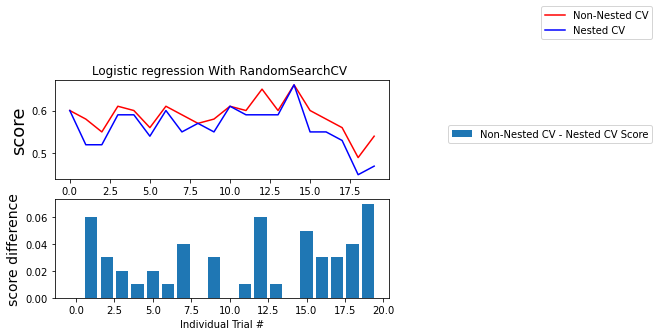

In [27]:
plt.figure()
plt.subplot(211)
plt.title('Logistic regression With RandomSearchCV ')
(non_nested_scores_line,) = plt.plot(non_nested_scores_1, color="r")
(nested_line,) = plt.plot(nested_scores_1, color="b")
plt.ylabel("score", fontsize="18")
plt.legend(
    [non_nested_scores_line, nested_line],
    ["Non-Nested CV", "Nested CV"],
    bbox_to_anchor=(0, 1.8, 1.8, 0),
)
plt.subplot(212)
difference_plot = plt.bar(range(num_of_rand_trials), difference_of_Score)
plt.xlabel("Individual Trial #")
plt.legend(
    [difference_plot],
    ["Non-Nested CV - Nested CV Score"],
    bbox_to_anchor=(0, 1.8, 1.8, 0),
)
plt.ylabel("score difference", fontsize="14")

plt.show()

### Support Vactor Machine 

In [28]:
from sklearn.svm import SVC

In [29]:
model2 = SVC(gamma='auto')
model2.fit(X_train, y_train)
model2 .score(X_test, y_test)

0.92

In [30]:
y_pred2 = model2.predict(X_test)

In [31]:
#Model Evaluating using Confusion Matrix
from sklearn import metrics
confusion_Matrix2 = metrics.confusion_matrix(y_test, y_pred2)
print(confusion_Matrix2)

[[10  0]
 [ 2 13]]


Text(0.5, 257.44, 'Predicted label')

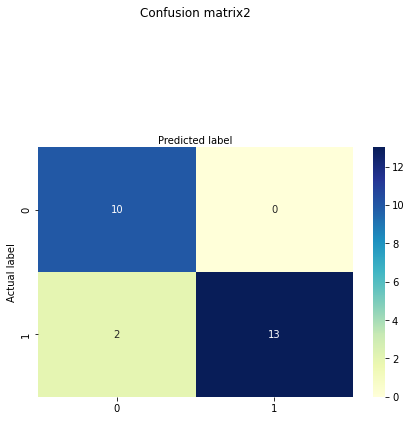

In [32]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(confusion_Matrix2), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix2', y=1.5)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [33]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred2))
print("Precision:",metrics.precision_score(y_test, y_pred2))
print("Recall:",metrics.recall_score(y_test, y_pred2))

Accuracy: 0.92
Precision: 1.0
Recall: 0.8666666666666667


svm model performance using cross_val_score

In [34]:
# Evaluate model
scores2 = cross_val_score(SVC(gamma='auto'), X1, y1,scoring= 'accuracy', cv=cv_outer, n_jobs=1)
print('Accuracy: %.3f (%.3f)' % (mean(scores2), std(scores2)))

Accuracy: 0.940 (0.066)


Perform Non-nested and Nested cross-validation With Support vector Machine

In [35]:
opti_grid_para2 = {"C": [0.01, 0.1, 1, 10, 100],
                  "gamma": [0.01, 0.1, 1, 10, 100]}

In [36]:
# Support vector Classifier with rbf kernal
model2= SVC(kernel= "rbf")

In [37]:
nested_scores_2  = np.zeros(num_of_rand_trials)
non_nested_scores_2 = np.zeros(num_of_rand_trials)


In [38]:
for i in range(num_of_rand_trials):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits=2, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=model2, param_grid=opti_grid_para2, cv=outer_cv)
    clf.fit(X1_data, y1_target)
    non_nested_scores_2[i] = clf.best_score_

    # Nested CV with parameter optimization
    clf = GridSearchCV(estimator=model2, param_grid=opti_grid_para2, cv=inner_cv)
    nested_score_2 = cross_val_score(clf, X=X1_data, y=y1_target, cv=outer_cv)
    nested_scores_2[i] = nested_score_2.mean()

In [39]:
print(non_nested_scores_2, nested_scores_2)

[0.96 0.97 0.96 0.96 0.96 0.96 0.96 0.97 0.96 0.96 0.97 0.96 0.96 0.96
 0.95 0.97 0.96 0.95 0.94 0.96] [0.97 0.95 0.95 0.97 0.95 0.93 0.94 0.98 0.92 0.94 0.91 0.93 0.93 0.93
 0.93 0.94 0.91 0.94 0.95 0.95]


In [40]:
difference_of_Score = non_nested_scores_2 - nested_scores_2

print(
    "Average difference of {:3f} with std. dev. of {:3f}.".format(
        difference_of_Score.mean(), difference_of_Score.std()
    )
)

Average difference of 0.019000 with std. dev. of 0.019209.


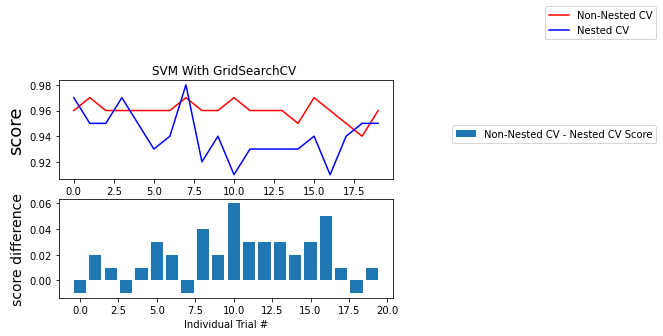

In [41]:
plt.figure()
plt.subplot(211)
plt.title('SVM With GridSearchCV ')
(non_nested_scores_line,) = plt.plot(non_nested_scores_2, color="r")
(nested_line,) = plt.plot(nested_scores_2, color="b")
plt.ylabel("score", fontsize="18")
plt.legend(
    [non_nested_scores_line, nested_line],
    ["Non-Nested CV", "Nested CV"],
    bbox_to_anchor=(0, 1.8, 1.8, 0),
)
plt.subplot(212)
difference_plot = plt.bar(range(num_of_rand_trials), difference_of_Score)
plt.xlabel("Individual Trial #")
plt.legend(
    [difference_plot],
    ["Non-Nested CV - Nested CV Score"],
    bbox_to_anchor=(0, 1.8, 1.8, 0),
)
plt.ylabel("score difference", fontsize="14")

plt.show()

Perform Non-nested and Nested cross-validation on Support vector Machine With Randomized SearchCV

In [42]:
for i in range(num_of_rand_trials):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits=2, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=i)


    # Non_nested parameter search and scoring
    clf = RandomizedSearchCV(estimator=model2, param_distributions=opti_grid_para2, cv=outer_cv)
    clf.fit(X1_data, y1_target)
    non_nested_scores_2[i] = clf.best_score_

    # Nested CV with parameter optimization
    clf = RandomizedSearchCV(estimator=model2, param_distributions=opti_grid_para2, cv=inner_cv)
    nested_score_2 = cross_val_score(clf, X=X1_data, y=y1_target, cv=outer_cv)
    nested_scores_2[i] = nested_score_2.mean()

In [43]:
print(non_nested_scores_2, nested_score_2)

[0.96 0.97 0.96 0.96 0.96 0.96 0.95 0.97 0.95 0.96 0.96 0.96 0.95 0.95
 0.95 0.96 0.96 0.95 0.94 0.96] [0.95 1.   0.95 0.9  0.9 ]


In [44]:
difference_of_Score = non_nested_scores_2 - nested_scores_2

print(
    "Average difference of {:3f} with std. dev. of {:3f}.".format(
        difference_of_Score.mean(), difference_of_Score.std()
    )
)

Average difference of 0.013500 with std. dev. of 0.011948.


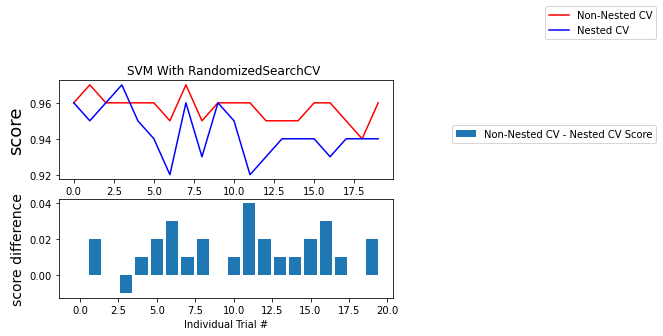

In [45]:
plt.figure()
plt.subplot(211)
plt.title('SVM With RandomizedSearchCV ')
(non_nested_scores_line,) = plt.plot(non_nested_scores_2, color="r")
(nested_line,) = plt.plot(nested_scores_2, color="b")
plt.ylabel("score", fontsize="18")
plt.legend(
    [non_nested_scores_line, nested_line],
    ["Non-Nested CV", "Nested CV"],
    bbox_to_anchor=(0, 1.8, 1.8, 0),
)
plt.subplot(212)
difference_plot = plt.bar(range(num_of_rand_trials), difference_of_Score)
plt.xlabel("Individual Trial #")
plt.legend(
    [difference_plot],
    ["Non-Nested CV - Nested CV Score"],
    bbox_to_anchor=(0, 1.8, 1.8, 0),
)
plt.ylabel("score difference", fontsize="14")

plt.show()

### Decision-tree algorithm

In [46]:
from sklearn.tree import DecisionTreeClassifier

In [47]:
model3 = DecisionTreeClassifier(random_state=42)
model3.fit(X_train, y_train)
model3.score(X_test,y_test)

0.96

In [48]:
y_pred3= model3.predict(X_test)


In [49]:
#Model Evaluating using Confusion Matrix
from sklearn import metrics
confusion_Matrix3 = metrics.confusion_matrix(y_test, y_pred3)
print(confusion_Matrix3)

[[10  0]
 [ 1 14]]


Text(0.5, 257.44, 'Predicted label')

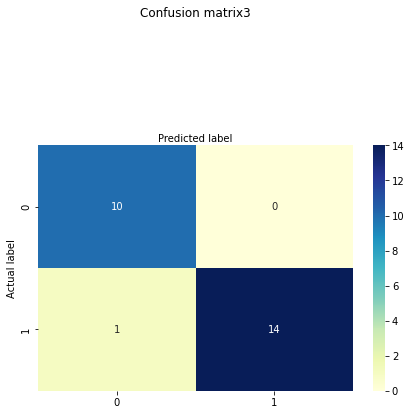

In [50]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(confusion_Matrix3), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix3', y=1.5)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Decision-tree algorithm using cross_val_score

In [51]:
# Evaluate model

scores3 = cross_val_score(model3, X1, y1,scoring= 'accuracy', cv=cv_outer, n_jobs=1)
print('Accuracy: %.3f (%.3f)' % (mean(scores3), std(scores3)))

Accuracy: 0.960 (0.049)


In [52]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred3))
print("Precision:",metrics.precision_score(y_test, y_pred3))
print("Recall:",metrics.recall_score(y_test, y_pred3))

Accuracy: 0.96
Precision: 1.0
Recall: 0.9333333333333333


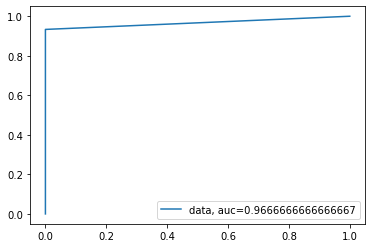

In [53]:
y_pred_proba2 = model3.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba2)
auc = metrics.roc_auc_score(y_test, y_pred_proba2)
plt.plot(fpr,tpr,label="data, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Decision-tree algorithm using Nested and Non-Nested cross_val_score With GridSearchCV

In [54]:
opti_grid_para3 = {'max_leaf_nodes': list(range(2, 50)), 
                  'min_samples_split': [2, 3, 4]}

In [55]:
nested_scores_3  = np.zeros(num_of_rand_trials)
non_nested_scores_3 = np.zeros(num_of_rand_trials)

In [56]:
for i in range(num_of_rand_trials):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits=2, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=i)


    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=model3, param_grid=opti_grid_para3, cv=outer_cv)
    clf.fit(X1_data, y1_target)
    non_nested_scores_3[i] = clf.best_score_

    # Nested CV with parameter optimization
    clf = GridSearchCV(estimator=model3, param_grid=opti_grid_para3, cv=inner_cv)
    nested_score_3 = cross_val_score(clf, X=X1_data, y=y1_target, cv=outer_cv)
    nested_scores_3[i] = nested_score_3.mean()

In [57]:
print(non_nested_scores_3, nested_scores_3)

[0.94 0.95 0.96 0.95 0.93 0.97 0.95 0.95 0.95 0.95 0.95 0.96 0.96 0.95
 0.94 0.95 0.96 0.92 0.94 0.93] [0.94 0.95 0.94 0.93 0.9  0.91 0.95 0.95 0.95 0.95 0.94 0.92 0.96 0.95
 0.94 0.95 0.87 0.92 0.94 0.93]


In [58]:
difference_of_Score = non_nested_scores_3 - nested_scores_3

print(
    "Average difference of {:3f} with std. dev. of {:3f}.".format(
        difference_of_Score.mean(), difference_of_Score.std()
    )
)

Average difference of 0.013500 with std. dev. of 0.023932.


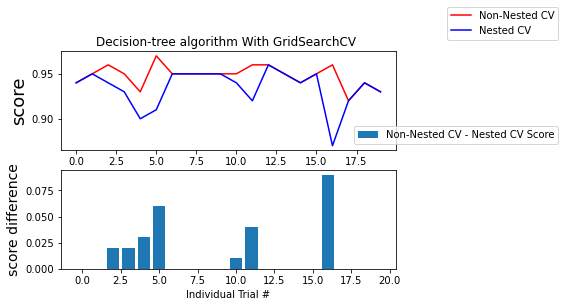

In [59]:
plt.figure()
plt.subplot(211)
plt.title('Decision-tree algorithm With GridSearchCV ')
(non_nested_scores_line,) = plt.plot(non_nested_scores_3, color="r")
(nested_line,) = plt.plot(nested_scores_3, color="b")
plt.ylabel("score", fontsize="18")
plt.legend(
    [non_nested_scores_line, nested_line],
    ["Non-Nested CV", "Nested CV"],
    bbox_to_anchor=(0, 1.5, 1.5, 0),
)
plt.subplot(212)
difference_plot = plt.bar(range(num_of_rand_trials), difference_of_Score)
plt.xlabel("Individual Trial #")
plt.legend(
    [difference_plot],
    ["Non-Nested CV - Nested CV Score"],
    bbox_to_anchor=(0, 1.5, 1.5, 0),
)
plt.ylabel("score difference", fontsize="14")

plt.show()

Decision-tree algorithm using Nested and Non-Nested cross_val_score With RandomizedSearchCV

In [60]:
for i in range(num_of_rand_trials):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits=2, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = RandomizedSearchCV(estimator=model3, param_distributions=opti_grid_para3, cv=outer_cv)
    clf.fit(X1_data, y1_target)
    non_nested_scores_3[i] = clf.best_score_

    # Nested CV with parameter optimization
    clf = RandomizedSearchCV(estimator=model3, param_distributions=opti_grid_para3, cv=inner_cv)
    nested_score_3 = cross_val_score(clf, X=X1_data, y=y1_target, cv=outer_cv)
    nested_scores_3[i] = nested_score_3.mean()

In [61]:
print(non_nested_scores_3, nested_scores_3)

[0.94 0.95 0.96 0.95 0.93 0.97 0.95 0.95 0.95 0.95 0.95 0.96 0.96 0.95
 0.94 0.95 0.96 0.92 0.94 0.93] [0.93 0.95 0.96 0.95 0.93 0.97 0.95 0.95 0.95 0.95 0.95 0.96 0.96 0.95
 0.94 0.95 0.95 0.92 0.94 0.93]


In [62]:
difference_of_Score = non_nested_scores_3 - nested_scores_3

print(
    "Average difference of {:3f} with std. dev. of {:3f}.".format(
        difference_of_Score.mean(), difference_of_Score.std()
    )
)

Average difference of 0.001000 with std. dev. of 0.003000.


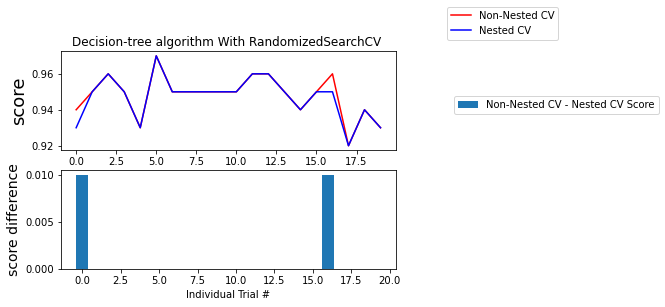

In [63]:
plt.figure()
plt.subplot(211)
plt.title('Decision-tree algorithm With RandomizedSearchCV ')
(non_nested_scores_line,) = plt.plot(non_nested_scores_3, color="r")
(nested_line,) = plt.plot(nested_scores_3, color="b")
plt.ylabel("score", fontsize="18")
plt.legend(
    [non_nested_scores_line, nested_line],
    ["Non-Nested CV", "Nested CV"],
    bbox_to_anchor=(0, 1.5, 1.5, 0),
)
plt.subplot(212)
difference_plot = plt.bar(range(num_of_rand_trials), difference_of_Score)
plt.xlabel("Individual Trial #")
plt.legend(
    [difference_plot],
    ["Non-Nested CV - Nested CV Score"],
    bbox_to_anchor=(0, 1.8, 1.8, 0),
)
plt.ylabel("score difference", fontsize="14")

plt.show()

### Gradient Boosting-tree algorithm

Perform Binary Classification dataset a gradient boosting-tree algorithm.

   Gradient boosting is a machine learning technique for classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees.


   The objective of any supervised learning algorithm is to define a loss function and minimize it. The same is true for Gradient Boosting algorithm. Here, we have mean squared error (MSE) as loss-function 



In [64]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [65]:
model4 = GradientBoostingClassifier(
    max_depth=2,
    n_estimators=3,
    learning_rate=1.0
)
model4.fit(X_train, y_train)
model4.score(X_test, y_test)


0.88

In [66]:
y_pred4= model4.predict(X_test)
mean_absolute_error(y_test, y_pred4)


0.12

In [67]:
#errors = [mean_squared_error(y_test, y_pred4) 
#                   for y_pred4 in model4.staged_predict(X_test)]
#best_n_estimators = np.argmin(errors)



In [68]:
#best_model4 = GradientBoostingClassifier(
#    max_depth=2,
#    n_estimators=best_n_estimators,
#    learning_rate=1.0
#)
#best_model4.fit(X_train, y_train)
#best_model4.score(X_test, y_test)
#y_pred5 = best_model4.predict(X_test)

In [69]:
#Model Evaluating using Confusion Matrix
from sklearn import metrics
confusion_Matrix4 = metrics.confusion_matrix(y_test, y_pred4)
print(confusion_Matrix4)

[[10  0]
 [ 3 12]]


Text(0.5, 257.44, 'Predicted label')

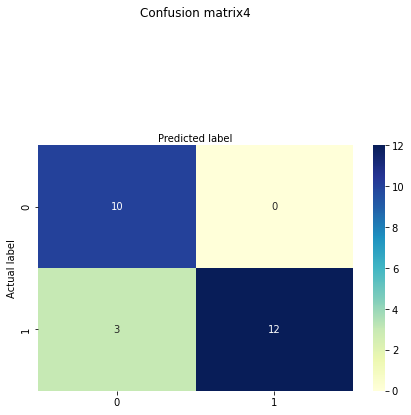

In [70]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(confusion_Matrix4), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix4', y=1.5)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [71]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred4))
print("Precision:",metrics.precision_score(y_test, y_pred4))
print("Recall:",metrics.recall_score(y_test, y_pred4))

Accuracy: 0.88
Precision: 1.0
Recall: 0.8


Gradient Boosting Classifier With cross_val_score


In [72]:
scores4 = cross_val_score(model4, X1, y1,scoring= 'accuracy', cv=cv_outer, n_jobs=1)
print('Accuracy: %.3f (%.3f)' % (mean(scores4), std(scores4)))

Accuracy: 0.970 (0.046)


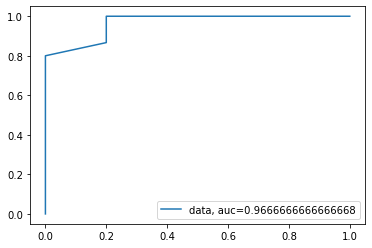

In [73]:
y_pred_proba3 = model4.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba3)
auc = metrics.roc_auc_score(y_test, y_pred_proba3)
plt.plot(fpr,tpr,label="data, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Gradient Boosting algorithm using Nested and Non-Nested cross_val_score With GridSearchCV

In [74]:
opti_grid_para4 = dict(
    n_estimators=[100, 500],
    max_depth=[1, 2, 3]
)

In [75]:
nested_scores_4  = np.zeros(num_of_rand_trials)
non_nested_scores_4 = np.zeros(num_of_rand_trials)

In [76]:
for i in range(num_of_rand_trials):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits=2, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=i)


    # Non_nested parameter GridSearchCV search and scoring
    clf = GridSearchCV(estimator=model4, param_grid=opti_grid_para4, cv=outer_cv)
    clf.fit(X1_data, y1_target)
    non_nested_scores_4[i] = clf.best_score_

    # Nested CV with parameter GridSearchCV optimization
    clf = GridSearchCV(estimator=model4, param_grid=opti_grid_para4, cv=inner_cv)
    nested_score_4 = cross_val_score(clf, X=X1_data, y=y1_target, cv=outer_cv)
    nested_scores_4[i] = nested_score_4.mean()
    


In [77]:
print(non_nested_scores_4, nested_scores_4)

[0.97 0.97 0.97 0.96 0.96 0.98 0.98 0.98 0.99 0.98 0.98 0.98 0.98 0.98
 0.97 0.97 0.95 0.96 0.99 0.95] [0.96 0.97 0.96 0.96 0.95 0.98 0.99 0.97 0.99 0.97 0.98 0.98 0.98 0.97
 0.97 0.97 0.94 0.95 0.97 0.96]


In [78]:
difference_of_Score = non_nested_scores_4 - nested_scores_4

print(
    "Average difference of {:3f} with std. dev. of {:3f}.".format(
        difference_of_Score.mean(), difference_of_Score.std()
    )
)

Average difference of 0.004000 with std. dev. of 0.007348.


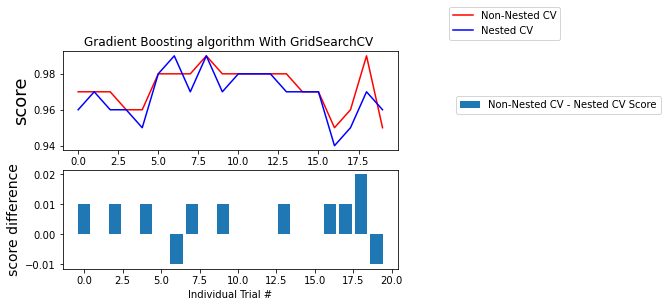

In [79]:
plt.figure()
plt.subplot(211)
plt.title('Gradient Boosting algorithm With GridSearchCV ')
(non_nested_scores_line,) = plt.plot(non_nested_scores_4, color="r")
(nested_line,) = plt.plot(nested_scores_4, color="b")
plt.ylabel("score", fontsize="18")
plt.legend(
    [non_nested_scores_line, nested_line],
    ["Non-Nested CV", "Nested CV"],
    bbox_to_anchor=(0, 1.5, 1.5, 0),
)
plt.subplot(212)
difference_plot = plt.bar(range(num_of_rand_trials), difference_of_Score)
plt.xlabel("Individual Trial #")
plt.legend(
    [difference_plot],
    ["Non-Nested CV - Nested CV Score"],
    bbox_to_anchor=(0, 1.8, 1.8, 0),
)
plt.ylabel("score difference", fontsize="14")

plt.show()

Gradient Boosting algorithm using Nested and Non-Nested cross_val_score With RandomizedSearchCV

In [80]:
for i in range(num_of_rand_trials):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits=2, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=i)


    # Non_nested parameter search and scoring
    clf = RandomizedSearchCV(estimator=model4, param_distributions=opti_grid_para4, cv=outer_cv)
    clf.fit(X1_data, y1_target)
    non_nested_scores_4[i] = clf.best_score_

    # Nested CV with parameter optimization
    clf = RandomizedSearchCV(estimator=model4, param_distributions=opti_grid_para4, cv=inner_cv)
    nested_score_4 = cross_val_score(clf, X=X1_data, y=y1_target, cv=outer_cv)
    nested_scores_4[i] = nested_score_4.mean()

In [81]:
print(non_nested_scores_4, nested_scores_4)

[0.97 0.97 0.97 0.96 0.96 0.98 0.98 0.98 0.99 0.98 0.98 0.98 0.98 0.98
 0.97 0.97 0.95 0.96 0.99 0.95] [0.96 0.97 0.96 0.96 0.95 0.98 0.98 0.96 0.99 0.97 0.98 0.98 0.98 0.97
 0.97 0.97 0.94 0.95 0.97 0.96]


In [82]:
difference_of_Score = non_nested_scores_4 - nested_scores_4

print(
    "Average difference of {:3f} with std. dev. of {:3f}.".format(
        difference_of_Score.mean(), difference_of_Score.std()
    )
)

Average difference of 0.005000 with std. dev. of 0.007416.


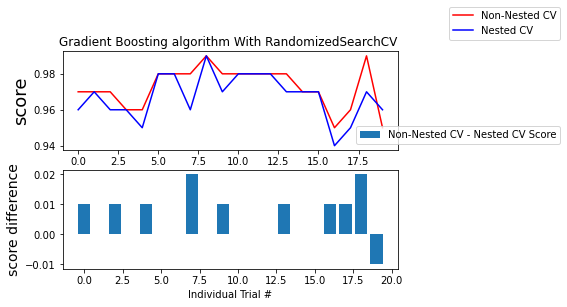

In [83]:
plt.figure()
plt.subplot(211)
plt.title('Gradient Boosting algorithm With RandomizedSearchCV ')
(non_nested_scores_line,) = plt.plot(non_nested_scores_4, color="r")
(nested_line,) = plt.plot(nested_scores_4, color="b")
plt.ylabel("score", fontsize="18")
plt.legend(
    [non_nested_scores_line, nested_line],
    ["Non-Nested CV", "Nested CV"],
    bbox_to_anchor=(0, 1.5, 1.5, 0),
)
plt.subplot(212)
difference_plot = plt.bar(range(num_of_rand_trials), difference_of_Score)
plt.xlabel("Individual Trial #")
plt.legend(
    [difference_plot],
    ["Non-Nested CV - Nested CV Score"],
    bbox_to_anchor=(0, 1.5, 1.5, 0),
)
plt.ylabel("score difference", fontsize="14")

plt.show()

### K-Nearest Neighbors


In [84]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [85]:
model5 = KNeighborsClassifier(algorithm='ball_tree',
                            leaf_size=5)
model5.fit(X_train, y_train)
model5.score(X_test, y_test)

0.92

In [86]:
y_pred5= model5.predict(X_test)

In [87]:
from sklearn import metrics
confusion_Matrix5 = metrics.confusion_matrix(y_test, y_pred5)
print(confusion_Matrix5)

[[10  0]
 [ 2 13]]


Text(0.5, 257.44, 'Predicted label')

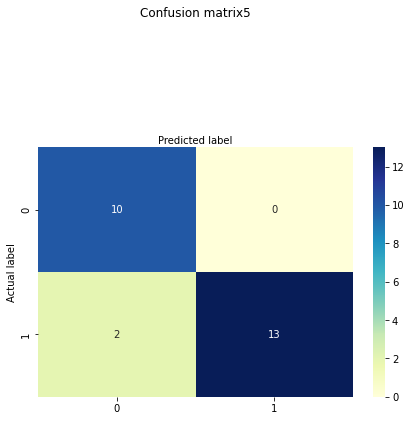

In [88]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(confusion_Matrix5), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix5', y=1.5)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [89]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred5))
print("Precision:",metrics.precision_score(y_test, y_pred5))
print("Recall:",metrics.recall_score(y_test, y_pred5))

Accuracy: 0.92
Precision: 1.0
Recall: 0.8666666666666667


In [90]:
scores5 = cross_val_score(model5, X1, y1,scoring= 'accuracy', cv=cv_outer, n_jobs=1)
print('Accuracy: %.3f (%.3f)' % (mean(scores5), std(scores5)))

Accuracy: 0.890 (0.094)


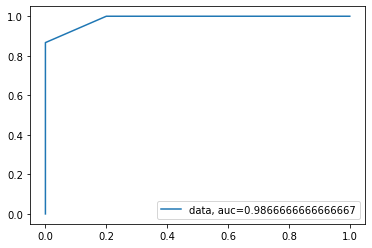

In [91]:
y_pred_proba = model5.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [92]:
opti_grid_para5 = [{'n_neighbors': list(range(1, 10)),
                     'p': [1, 2]}]

In [93]:
nested_scores_1  = np.zeros(num_of_rand_trials)
non_nested_scores_1 = np.zeros(num_of_rand_trials)

In [94]:
for i in range(num_of_rand_trials):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits=2, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=i)


    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=model5, param_grid=opti_grid_para5, cv=outer_cv)
    clf.fit(X1_data, y1_target)
    non_nested_scores_1[i] = clf.best_score_

    # Nested CV with parameter optimization
    clf = GridSearchCV(estimator=model5, param_grid=opti_grid_para5, cv=inner_cv)
    nested_score_1 = cross_val_score(clf, X=X1_data, y=y1_target, cv=outer_cv)
    nested_scores_1[i] = nested_score_1.mean()

In [95]:
print(non_nested_scores_1, nested_scores_1)

[0.94 0.95 0.95 0.94 0.93 0.94 0.94 0.94 0.93 0.95 0.91 0.94 0.92 0.94
 0.93 0.95 0.89 0.95 0.95 0.95] [0.93 0.95 0.95 0.93 0.93 0.93 0.93 0.92 0.93 0.9  0.91 0.93 0.92 0.89
 0.92 0.93 0.86 0.95 0.93 0.92]


In [96]:
difference_of_Score = non_nested_scores_1 - nested_scores_1

print(
    "Average difference of {:3f} with std. dev. of {:3f}.".format(
        difference_of_Score.mean(), difference_of_Score.std()
    )
)

Average difference of 0.014000 with std. dev. of 0.015297.


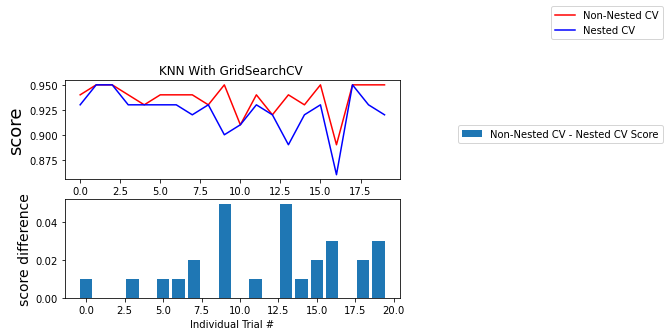

In [97]:
plt.figure()
plt.subplot(211)
plt.title('KNN With GridSearchCV ')
(non_nested_scores_line,) = plt.plot(non_nested_scores_1, color="r")
(nested_line,) = plt.plot(nested_scores_1, color="b")
plt.ylabel("score", fontsize="18")
plt.legend(
    [non_nested_scores_line, nested_line],
    ["Non-Nested CV", "Nested CV"],
    bbox_to_anchor=(0, 1.8, 1.8, 0),
)
plt.subplot(212)
difference_plot = plt.bar(range(num_of_rand_trials), difference_of_Score)
plt.xlabel("Individual Trial #")
plt.legend(
    [difference_plot],
    ["Non-Nested CV - Nested CV Score"],
    bbox_to_anchor=(0, 1.8, 1.8, 0),
)
plt.ylabel("score difference", fontsize="14")

plt.show()

In [98]:
for i in range(num_of_rand_trials):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits=2, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=i)


    
    # Non_nested parameter search and scoring
    clf = RandomizedSearchCV(estimator=model5, param_distributions=opti_grid_para5, cv=outer_cv)
    clf.fit(X1_data, y1_target)
    non_nested_scores_1[i] = clf.best_score_

    # Nested CV with parameter optimization
    clf = RandomizedSearchCV(estimator=model5, param_distributions=opti_grid_para5, cv=inner_cv)
    nested_score_1 = cross_val_score(clf, X=X1_data, y=y1_target, cv=outer_cv)
    nested_scores_1[i] = nested_score_1.mean()

In [99]:
print(non_nested_scores_1, nested_scores_1)

[0.94 0.95 0.95 0.94 0.92 0.94 0.94 0.93 0.93 0.95 0.91 0.94 0.92 0.94
 0.93 0.94 0.88 0.95 0.95 0.94] [0.94 0.94 0.95 0.92 0.93 0.92 0.9  0.92 0.93 0.93 0.89 0.93 0.92 0.91
 0.92 0.93 0.88 0.93 0.95 0.92]


In [100]:
difference_of_Score = non_nested_scores_1 - nested_scores_1

print(
    "Average difference of {:3f} with std. dev. of {:3f}.".format(
        difference_of_Score.mean(), difference_of_Score.std()
    )
)

Average difference of 0.011500 with std. dev. of 0.011948.


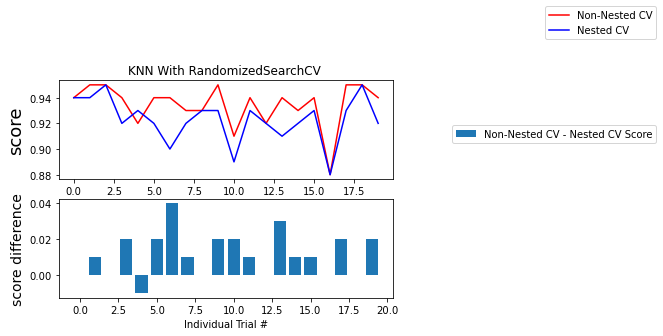

In [101]:
plt.figure()
plt.subplot(211)
plt.title('KNN With RandomizedSearchCV ')
(non_nested_scores_line,) = plt.plot(non_nested_scores_1, color="r")
(nested_line,) = plt.plot(nested_scores_1, color="b")
plt.ylabel("score", fontsize="18")
plt.legend(
    [non_nested_scores_line, nested_line],
    ["Non-Nested CV", "Nested CV"],
    bbox_to_anchor=(0, 1.8, 1.8, 0),
)
plt.subplot(212)
difference_plot = plt.bar(range(num_of_rand_trials), difference_of_Score)
plt.xlabel("Individual Trial #")
plt.legend(
    [difference_plot],
    ["Non-Nested CV - Nested CV Score"],
    bbox_to_anchor=(0, 1.8, 1.8, 0),
)
plt.ylabel("score difference", fontsize="14")

plt.show()

### Random Forest

In [102]:
model6  = RandomForestClassifier(random_state=1)

In [103]:
model6.fit(X_train, y_train)
model6.score(X_test, y_test)

0.96

In [104]:
y_pred6= model6.predict(X_test)

In [105]:
from sklearn import metrics
confusion_Matrix6 = metrics.confusion_matrix(y_test, y_pred6)
print(confusion_Matrix6)

[[10  0]
 [ 1 14]]


Text(0.5, 257.44, 'Predicted label')

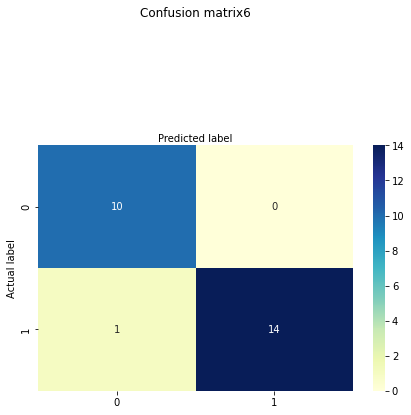

In [106]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(confusion_Matrix6), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix6', y=1.5)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [107]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred6))
print("Precision:",metrics.precision_score(y_test, y_pred6))
print("Recall:",metrics.recall_score(y_test, y_pred6))

Accuracy: 0.96
Precision: 1.0
Recall: 0.9333333333333333


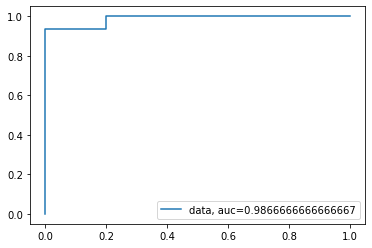

In [108]:
y_pred_proba = model6.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [109]:
# Evaluate model
scores6 = cross_val_score(model6, X1, y1,scoring= 'accuracy', cv=cv_outer, n_jobs=1)
print('Accuracy: %.3f (%.3f)' % (mean(scores6), std(scores6)))

Accuracy: 0.960 (0.049)


Random Forest using Nested and Non-Nested cross_val_score With GridSearchCV

In [110]:
opti_grid_para6 = [{'n_estimators': [10, 100, 500]}]

In [111]:
nested_scores_1  = np.zeros(num_of_rand_trials)
non_nested_scores_1 = np.zeros(num_of_rand_trials)

In [112]:
for i in range(num_of_rand_trials):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits=2, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=model6, param_grid=opti_grid_para6, cv=outer_cv)
    clf.fit(X1_data, y1_target)
    non_nested_scores_1[i] = clf.best_score_

    # Nested CV with parameter optimization
    clf = GridSearchCV(estimator=model6, param_grid=opti_grid_para6, cv=inner_cv)
    nested_score_1 = cross_val_score(clf, X=X1_data, y=y1_target, cv=outer_cv)
    nested_scores_1[i] = nested_score_1.mean()

In [113]:
print(non_nested_scores_1, nested_scores_1)

[0.94 0.94 0.96 0.96 0.95 0.97 0.96 0.95 0.96 0.96 0.96 0.97 0.96 0.93
 0.96 0.95 0.95 0.93 0.96 0.95] [0.94 0.94 0.96 0.95 0.94 0.97 0.94 0.95 0.95 0.96 0.96 0.96 0.95 0.93
 0.96 0.94 0.93 0.92 0.96 0.96]


In [114]:
difference_of_Score = non_nested_scores_1 - nested_scores_1

print(
    "Average difference of {:3f} with std. dev. of {:3f}.".format(
        difference_of_Score.mean(), difference_of_Score.std()
    )
)

Average difference of 0.005000 with std. dev. of 0.007416.


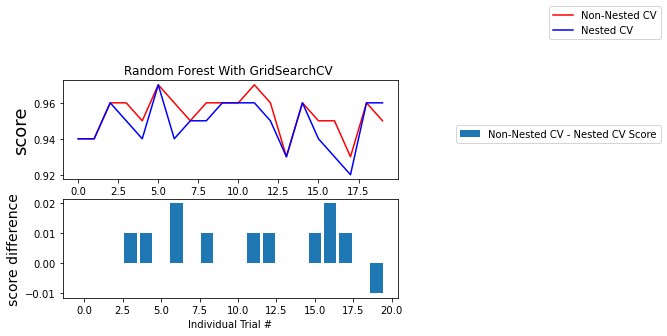

In [115]:
plt.figure()
plt.subplot(211)
plt.title('Random Forest With GridSearchCV ')
(non_nested_scores_line,) = plt.plot(non_nested_scores_1, color="r")
(nested_line,) = plt.plot(nested_scores_1, color="b")
plt.ylabel("score", fontsize="18")
plt.legend(
    [non_nested_scores_line, nested_line],
    ["Non-Nested CV", "Nested CV"],
    bbox_to_anchor=(0, 1.8, 1.8, 0),
)
plt.subplot(212)
difference_plot = plt.bar(range(num_of_rand_trials), difference_of_Score)
plt.xlabel("Individual Trial #")
plt.legend(
    [difference_plot],
    ["Non-Nested CV - Nested CV Score"],
    bbox_to_anchor=(0, 1.8, 1.8, 0),
)
plt.ylabel("score difference", fontsize="14")

plt.show()

Random Forest using Nested and Non-Nested cross_val_score With RandomizedSearchCV 

In [116]:
for i in range(num_of_rand_trials):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits=2, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=i)

    
    # Non_nested parameter search and scoring
    clf = RandomizedSearchCV(estimator=model6, param_distributions=opti_grid_para6, cv=outer_cv)
    clf.fit(X1_data, y1_target)
    non_nested_scores_1[i] = clf.best_score_

    # Nested CV with parameter optimization
    clf = RandomizedSearchCV(estimator=model6, param_distributions=opti_grid_para6, cv=inner_cv)
    nested_score_1 = cross_val_score(clf, X=X1_data, y=y1_target, cv=outer_cv)
    nested_scores_1[i] = nested_score_1.mean()

In [117]:
print(non_nested_scores_1, nested_scores_1)

[0.94 0.94 0.96 0.96 0.95 0.97 0.96 0.95 0.96 0.96 0.96 0.97 0.96 0.93
 0.96 0.95 0.95 0.93 0.96 0.95] [0.94 0.94 0.96 0.95 0.94 0.97 0.94 0.95 0.95 0.96 0.96 0.96 0.95 0.93
 0.96 0.94 0.93 0.92 0.96 0.96]


In [118]:
difference_of_Score = non_nested_scores_1 - nested_scores_1

print(
    "Average difference of {:3f} with std. dev. of {:3f}.".format(
        difference_of_Score.mean(), difference_of_Score.std()
    )
)

Average difference of 0.005000 with std. dev. of 0.007416.


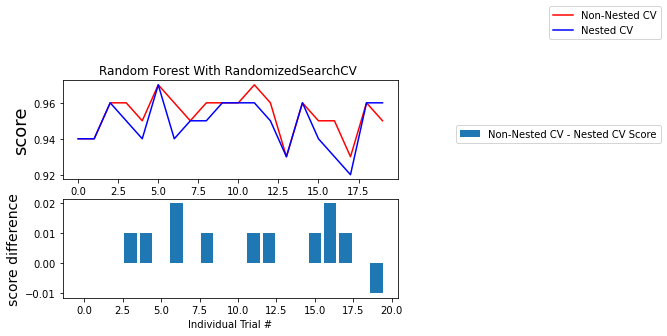

In [119]:
plt.figure()
plt.subplot(211)
plt.title('Random Forest With RandomizedSearchCV ')
(non_nested_scores_line,) = plt.plot(non_nested_scores_1, color="r")
(nested_line,) = plt.plot(nested_scores_1, color="b")
plt.ylabel("score", fontsize="18")
plt.legend(
    [non_nested_scores_line, nested_line],
    ["Non-Nested CV", "Nested CV"],
    bbox_to_anchor=(0, 1.8, 1.8, 0),
)
plt.subplot(212)
difference_plot = plt.bar(range(num_of_rand_trials), difference_of_Score)
plt.xlabel("Individual Trial #")
plt.legend(
    [difference_plot],
    ["Non-Nested CV - Nested CV Score"],
    bbox_to_anchor=(0, 1.8, 1.8, 0),
)
plt.ylabel("score difference", fontsize="14")

plt.show()

### Combined Model Plot with Nested and Non-Nested GridSearchCV and RandomizedSearchCV

In [120]:
num_of_trials = 5

In [121]:
nested_scores_m1 = np.zeros(num_of_trials)
nested_scores_m2 = np.zeros(num_of_trials)
nested_scores_m3 = np.zeros(num_of_trials)
nested_scores_m4 = np.zeros(num_of_trials)
nested_scores_m5 = np.zeros(num_of_trials)
nested_scores_m6 = np.zeros(num_of_trials)
non_nested_scores_m1 = np.zeros(num_of_trials)
non_nested_scores_m2 = np.zeros(num_of_trials)
non_nested_scores_m3 = np.zeros(num_of_trials)
non_nested_scores_m4 = np.zeros(num_of_trials)
non_nested_scores_m5 = np.zeros(num_of_trials)
non_nested_scores_m6 = np.zeros(num_of_trials)

In [123]:
for i in range(num_of_trials):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits=2, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf_m1 = GridSearchCV(estimator=model1, param_grid=opti_grid_para1, cv=outer_cv)
    clf_m2 = GridSearchCV(estimator=model2, param_grid=opti_grid_para2, cv=outer_cv)
    clf_m3 = GridSearchCV(estimator=model3, param_grid=opti_grid_para3, cv=outer_cv)
    clf_m4 = GridSearchCV(estimator=model4, param_grid=opti_grid_para4, cv=outer_cv)
    clf_m5 = GridSearchCV(estimator=model5, param_grid=opti_grid_para5, cv=outer_cv)
    clf_m6 = GridSearchCV(estimator=model6, param_grid=opti_grid_para6, cv=outer_cv)
    #clf.fit(X1_data, y1_target)
    clf_m1.fit(X1_data, y1_target)
    clf_m2.fit(X1_data, y1_target)
    clf_m3.fit(X1_data, y1_target)
    clf_m4.fit(X1_data, y1_target)
    clf_m5.fit(X1_data, y1_target)
    clf_m6.fit(X1_data, y1_target)

    non_nested_scores_m1[i] = clf_m1.best_score_
    non_nested_scores_m2[i] = clf_m2.best_score_
    non_nested_scores_m3[i] = clf_m3.best_score_
    non_nested_scores_m4[i] = clf_m4.best_score_
    non_nested_scores_m5[i] = clf_m5.best_score_
    non_nested_scores_m6[i] = clf_m6.best_score_

    # Nested CV with parameter optimization
    clf_m1 = GridSearchCV(estimator=model1, param_grid=opti_grid_para1, cv=inner_cv)
    clf_m2 = GridSearchCV(estimator=model2, param_grid=opti_grid_para2, cv=inner_cv)
    clf_m3 = GridSearchCV(estimator=model3, param_grid=opti_grid_para3, cv=inner_cv)
    clf_m4 = GridSearchCV(estimator=model4, param_grid=opti_grid_para4, cv=inner_cv)
    clf_m5 = GridSearchCV(estimator=model5, param_grid=opti_grid_para5, cv=inner_cv)
    clf_m6 = GridSearchCV(estimator=model6, param_grid=opti_grid_para6, cv=inner_cv)
    #clf = GridSearchCV(estimator=model6, param_grid=opti_grid_para6, cv=inner_cv)
    #nested_score_1 = cross_val_score(clf, X=X1_data, y=y1_target, cv=outer_cv)
    nested_scores_m1 = cross_val_score(clf_m1, X=X1_data, y=y1_target, cv=outer_cv)
    nested_scores_m2 = cross_val_score(clf_m2, X=X1_data, y=y1_target, cv=outer_cv)
    nested_scores_m3 = cross_val_score(clf_m3, X=X1_data, y=y1_target, cv=outer_cv)
    nested_scores_m4 = cross_val_score(clf_m4, X=X1_data, y=y1_target, cv=outer_cv)
    nested_scores_m5 = cross_val_score(clf_m5, X=X1_data, y=y1_target, cv=outer_cv)
    nested_scores_m6 = cross_val_score(clf_m6, X=X1_data, y=y1_target, cv=outer_cv)
    #nested_scores_1[i] = nested_score_1.mean()
    nested_scores_m1[i] = nested_scores_m1.mean()
    nested_scores_m2[i] = nested_scores_m2.mean()
    nested_scores_m3[i] = nested_scores_m3.mean()
    nested_scores_m4[i] = nested_scores_m4.mean()
    nested_scores_m5[i] = nested_scores_m5.mean()
    nested_scores_m6[i] = nested_scores_m6.mean()

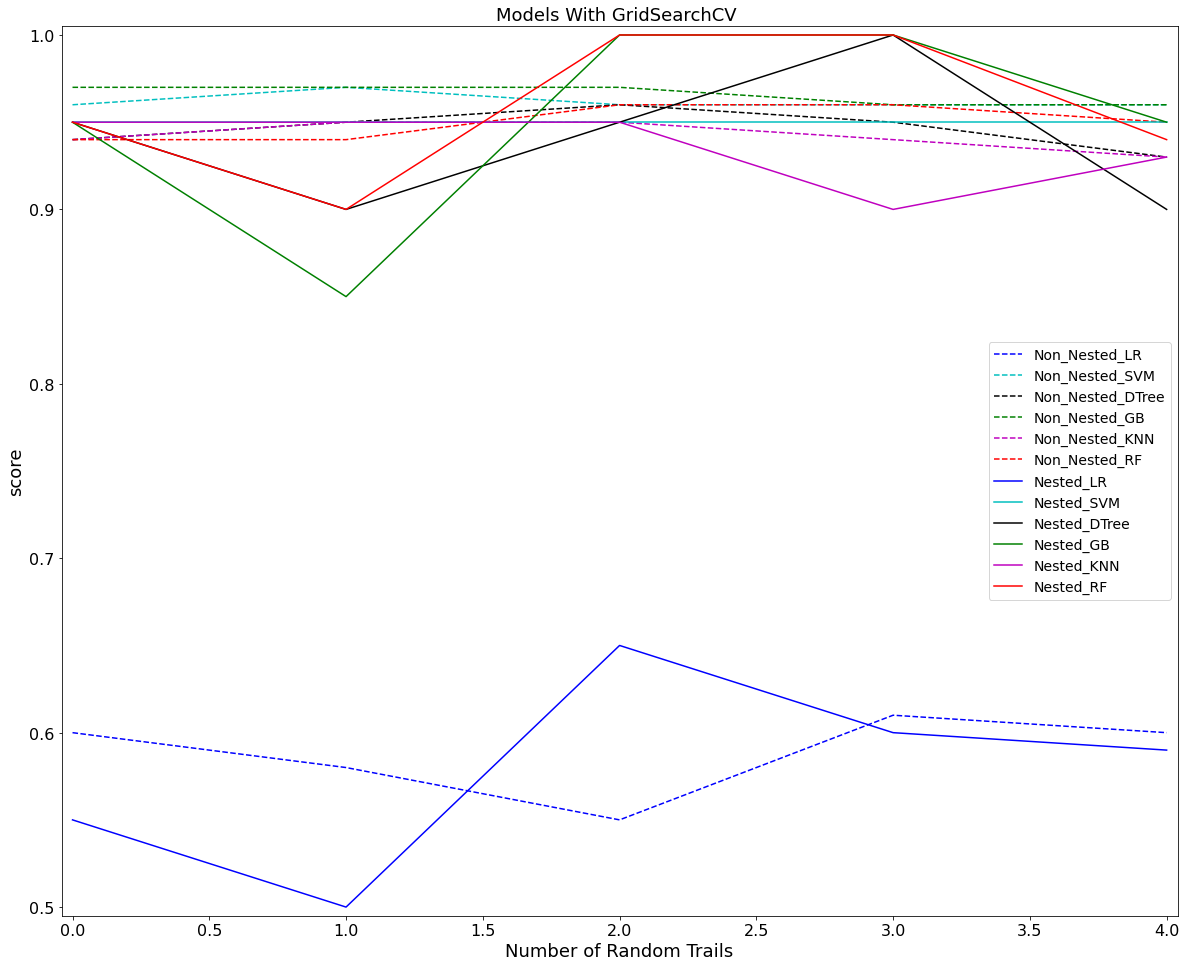

In [167]:
plt.figure(figsize=(20, 36))

ax = plt.subplot(211)
ax.margins(0.01)
plt.title('Models With GridSearchCV ', fontsize="18")
(non_nested_scores_line_m1,) = ax.plot(non_nested_scores_m1, color="b", linestyle="--", label="Non_Nested_LR")
(non_nested_scores_line_m2,) = ax.plot(non_nested_scores_m2, color="c", linestyle="--", label="Non_Nested_SVM")
(non_nested_scores_line_m3,) = ax.plot(non_nested_scores_m3, color="k", linestyle="--", label="Non_Nested_DTree")
(non_nested_scores_line_m4,) = ax.plot(non_nested_scores_m4, color="g", linestyle="--", label="Non_Nested_GB")
(non_nested_scores_line_m5,) = ax.plot(non_nested_scores_m5, color="m", linestyle="--", label="Non_Nested_KNN")
(non_nested_scores_line_m6,) = ax.plot(non_nested_scores_m6, color="r", linestyle="--", label="Non_Nested_RF")
(nested_line_m1,) = ax.plot(nested_scores_m1, color="b", label="Nested_LR")
(nested_line_m2,) = ax.plot(nested_scores_m2, color="c", label="Nested_SVM" )
(nested_line_m3,) = ax.plot(nested_scores_m3, color="k", label="Nested_DTree" )
(nested_line_m4,) = ax.plot(nested_scores_m4, color="g", label="Nested_GB" )
(nested_line_m5,) = ax.plot(nested_scores_m5, color="m", label="Nested_KNN" )
(nested_line_m6,) = ax.plot(nested_scores_m6, color="r", label="Nested_RF" )
plt.ylabel("score", fontsize="18")
plt.xlabel("Number of Random Trails", fontsize="18")
plt.xticks(fontsize = "16")
plt.yticks(fontsize = "16")
ax.legend(fontsize= "14")



In [169]:
for i in range(num_of_trials):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits=2, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf_m1 = RandomizedSearchCV(estimator=model1, param_distributions=opti_grid_para1, cv=outer_cv)
    clf_m2 = RandomizedSearchCV(estimator=model2, param_distributions=opti_grid_para2, cv=outer_cv)
    clf_m3 = RandomizedSearchCV(estimator=model3, param_distributions=opti_grid_para3, cv=outer_cv)
    clf_m4 = RandomizedSearchCV(estimator=model4, param_distributions=opti_grid_para4, cv=outer_cv)
    clf_m5 = RandomizedSearchCV(estimator=model5, param_distributions=opti_grid_para5, cv=outer_cv)
    clf_m6 = RandomizedSearchCV(estimator=model6, param_distributions=opti_grid_para6, cv=outer_cv)
    #clf.fit(X1_data, y1_target)
    clf_m1.fit(X1_data, y1_target)
    clf_m2.fit(X1_data, y1_target)
    clf_m3.fit(X1_data, y1_target)
    clf_m4.fit(X1_data, y1_target)
    clf_m5.fit(X1_data, y1_target)
    clf_m6.fit(X1_data, y1_target)

    non_nested_scores_m1[i] = clf_m1.best_score_
    non_nested_scores_m2[i] = clf_m2.best_score_
    non_nested_scores_m3[i] = clf_m3.best_score_
    non_nested_scores_m4[i] = clf_m4.best_score_
    non_nested_scores_m5[i] = clf_m5.best_score_
    non_nested_scores_m6[i] = clf_m6.best_score_

    # Nested CV with parameter optimization
    clf_m1 = RandomizedSearchCV(estimator=model1, param_distributions=opti_grid_para1, cv=inner_cv)
    clf_m2 = RandomizedSearchCV(estimator=model2, param_distributions=opti_grid_para2, cv=inner_cv)
    clf_m3 = RandomizedSearchCV(estimator=model3, param_distributions=opti_grid_para3, cv=inner_cv)
    clf_m4 = RandomizedSearchCV(estimator=model4, param_distributions=opti_grid_para4, cv=inner_cv)
    clf_m5 = RandomizedSearchCV(estimator=model5, param_distributions=opti_grid_para5, cv=inner_cv)
    clf_m6 = RandomizedSearchCV(estimator=model6, param_distributions=opti_grid_para6, cv=inner_cv)
    #clf = GridSearchCV(estimator=model6, param_grid=opti_grid_para6, cv=inner_cv)
    #nested_score_1 = cross_val_score(clf, X=X1_data, y=y1_target, cv=outer_cv)
    nested_scores_m1 = cross_val_score(clf_m1, X=X1_data, y=y1_target, cv=outer_cv)
    nested_scores_m2 = cross_val_score(clf_m2, X=X1_data, y=y1_target, cv=outer_cv)
    nested_scores_m3 = cross_val_score(clf_m3, X=X1_data, y=y1_target, cv=outer_cv)
    nested_scores_m4 = cross_val_score(clf_m4, X=X1_data, y=y1_target, cv=outer_cv)
    nested_scores_m5 = cross_val_score(clf_m5, X=X1_data, y=y1_target, cv=outer_cv)
    nested_scores_m6 = cross_val_score(clf_m6, X=X1_data, y=y1_target, cv=outer_cv)
    #nested_scores_1[i] = nested_score_1.mean()
    nested_scores_m1[i] = nested_scores_m1.mean()
    nested_scores_m2[i] = nested_scores_m2.mean()
    nested_scores_m3[i] = nested_scores_m3.mean()
    nested_scores_m4[i] = nested_scores_m4.mean()
    nested_scores_m5[i] = nested_scores_m5.mean()
    nested_scores_m6[i] = nested_scores_m6.mean()

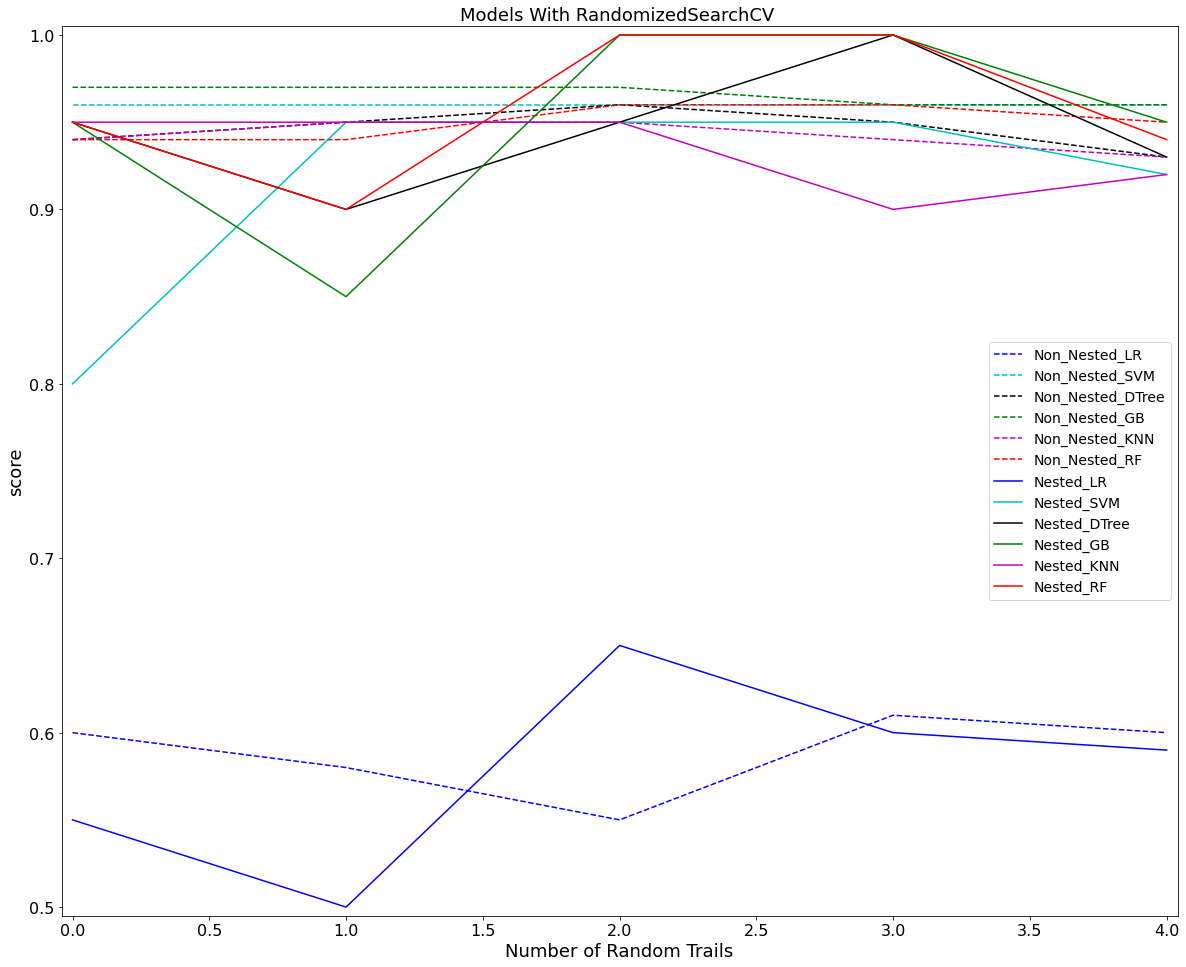

In [170]:
plt.figure(figsize=(20, 36))

ax = plt.subplot(211)
ax.margins(0.01)
plt.title('Models With RandomizedSearchCV ', fontsize="18")
(non_nested_scores_line_m1,) = ax.plot(non_nested_scores_m1, color="b", linestyle="--", label="Non_Nested_LR")
(non_nested_scores_line_m2,) = ax.plot(non_nested_scores_m2, color="c", linestyle="--", label="Non_Nested_SVM")
(non_nested_scores_line_m3,) = ax.plot(non_nested_scores_m3, color="k", linestyle="--", label="Non_Nested_DTree")
(non_nested_scores_line_m4,) = ax.plot(non_nested_scores_m4, color="g", linestyle="--", label="Non_Nested_GB")
(non_nested_scores_line_m5,) = ax.plot(non_nested_scores_m5, color="m", linestyle="--", label="Non_Nested_KNN")
(non_nested_scores_line_m6,) = ax.plot(non_nested_scores_m6, color="r", linestyle="--", label="Non_Nested_RF")
(nested_line_m1,) = ax.plot(nested_scores_m1, color="b", label="Nested_LR")
(nested_line_m2,) = ax.plot(nested_scores_m2, color="c", label="Nested_SVM" )
(nested_line_m3,) = ax.plot(nested_scores_m3, color="k", label="Nested_DTree" )
(nested_line_m4,) = ax.plot(nested_scores_m4, color="g", label="Nested_GB" )
(nested_line_m5,) = ax.plot(nested_scores_m5, color="m", label="Nested_KNN" )
(nested_line_m6,) = ax.plot(nested_scores_m6, color="r", label="Nested_RF" )
plt.ylabel("score", fontsize="18")
plt.xlabel("Number of Random Trails", fontsize="18")
plt.xticks(fontsize = "16")
plt.yticks(fontsize = "16")
ax.legend(fontsize= "14")